# Assignment 3: Cross Modal Search [190]

In this assignment, we'll introduce cross-modal search. We'll work with a dataset of images and their corresponding captions, where each image is associated with multiple descriptive captions. Our goal is to learn how to create contextual embeddings for different modalities (images and text) and build an efficient search mechanism that allows us to seamlessly navigate between these modalities. This will enable performing image-to-image, image-to-text, text-to-text, and text-to-image searches.

In [2]:
# !pip -q install datasets

import datasets
import warnings
import numpy as np
import torch
from tqdm import tqdm
import heapq
import time
import pprint
import matplotlib.pyplot as plt
import pickle
from typing import List, Tuple, Optional, Union, Generator

warnings.filterwarnings("ignore")

d:\Innopolis\ucheba\archive\informationRetrieval\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading and Exploration



Please download the dataset from the following link: [Dataset](https://drive.google.com/file/d/19KPsmsNhj6Q-W6yfYHud2K8EfPdWU2mc/view?usp=sharing).
Once downloaded, you can load and manage the data using the datasets library from Hugging Face.

In [3]:
arrow_file_path = "task_dataset/data-00000-of-00001.arrow"

dataset = datasets.load_dataset('arrow', data_files={'train': arrow_file_path})

dataset = dataset['train']
dataset

Generating train split: 15000 examples [00:00, 839801.38 examples/s]


Dataset({
    features: ['url', 'sentences'],
    num_rows: 15000
})

In [4]:
urls = dataset['url']
sentences = dataset['sentences']

print("First few url:", urls[:5])
print("First few sentences:", sentences[:5])

First few url: ['http://images.cocodataset.org/train2014/COCO_train2014_000000551159.jpg', 'http://images.cocodataset.org/train2014/COCO_train2014_000000343619.jpg', 'http://images.cocodataset.org/train2014/COCO_train2014_000000478087.jpg', 'http://images.cocodataset.org/train2014/COCO_train2014_000000070809.jpg', 'http://images.cocodataset.org/train2014/COCO_train2014_000000123923.jpg']
First few sentences: [['A young boy snowboards down a snowy track.', 'an image of a person skateboarding in the middle of winter', 'A kid rides on some sort of a ski track through the snow. ', 'A small child in a helmet learning how to ski', 'A small child using skis to ski down the hill.'], ['a person standing in the middle of a tennis court while playing a game ', 'A tennis player is moving to the side in order to hit the ball.', 'A man is perparing to hit the tennis ball.', 'A person running with a tennis racket on a tennis court.', 'The man braces himself to hit the tennis ball.'], ['Someone is loo

After running this code, you should observe that the dataset contains 15,000 images, each associated with a list of captions. Familiarizing yourself with the dataset structure is essential for the embedding generation and search tasks.

## Image Embedding Generation [10]

After loading the dataset, the next step is to create meaningful representations of the images in a vector format – image embeddings. These embeddings will capture the semantic essence of the images and enable you to perform similarity comparisons. You have the freedom to choose any embedding method that suits your needs like CNN pretraiend methods or VITs, etc..., but consider its effectiveness for similarity search.
Ensure you embed all images in the dataset using the same chosen method to maintain a comparable embedding space.



---


**Important Note**: It is not allowed to use the same embedding method for image and text, they should be different methods but it's totally fine and recommended if the vector dimensions after embedding of text and image are the same size.

Below find two helper functions to streamline the image loading and embedding process.

In [5]:
from torchvision import models, transforms
import numpy as np
from PIL import Image
import requests
import torch

model_img = models.resnet50(pretrained=True)
model_img.eval()

# Define preprocessing for images
# Normalizing according documentation 
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
])

def load_image_from_url(url: str) -> np.ndarray:
    """Loads an image from a given URL and converts it to an RGB NumPy array.

    Args:
        url: The URL of the image to load.

    Returns:
        A NumPy array representing the image in RGB format.
    """

    response = requests.get(url, stream=True)
    image = Image.open(response.raw).convert('RGB')

    return np.array(image)

def encode_image(image: str) -> np.ndarray:
    """Encodes a given image URL into an embedding vector.

    Args:
        image:  The URL of the image to encode.

    Returns:
         A NumPy array representing the image embedding.
    """

    # Load and preprocess the image
    raw_image = load_image_from_url(image)
    processed_image = image_transform(Image.fromarray(raw_image)).unsqueeze(0)
    
    # Generate image embedding
    with torch.no_grad():
        embedding = model_img(processed_image)

    return embedding.squeeze().numpy()


In [ ]:
import pickle
from sklearn.decomposition import PCA

image_data = []

for url in tqdm(urls[:768], desc="Encoding images"): 
    try:
        embedding = encode_image(url)
        image_data.append(embedding)
    except Exception as e:
        print(f"Error encoding image at {url}: {e}")

image_data_array = np.array(image_data)

# Reducing dimensionality using sklern PCA 
pca = PCA(n_components=768)
reduced_image_data = pca.fit_transform(image_data_array)  

print("Dimensionality reduced:")
print("Original shape:", image_data_array.shape)
print("Reduced shape:", reduced_image_data.shape)

with open('image_data.pkl', 'wb') as f:
    pickle.dump(image_data, f)

Dimensionality reduced:
Original shape: (15000, 1000)
Reduced shape: (15000, 768)


In [15]:
image_data = []
with open('image_data.pkl', 'rb') as f:
    image_data = pickle.load(f)

## Text Embedding Generation [20]

Similar to what you did when you created embeddings for images, you now need to generate embeddings for the text captions. It's important to consider the multi-caption nature of the data, each image has multiple associated captions, and you should represent this effectively in the text embeddings. Similar to the choice made with image dimension size you should maintain consistency of text dimension embeddign, choosing a good way to embed all captions per image is important to achieve good results.

In [ ]:
from sentence_transformers import SentenceTransformer
from typing import List

model_text = SentenceTransformer('all-MiniLM-L6-v2')

def encode_text(captions: List[List[str]]) -> List[np.ndarray]:
    """
    Encodes a list of captions (one list per image) into a list of text embeddings.

    Args:
      captions: A list of lists, where each inner list contains captions for a single image.

    Returns:
      A list of NumPy arrays, where each array represents embedding for an image's captions.
    """

    text_embeddings = []
    
    for caption_list in tqdm(captions, desc="Encoding captions"):

        caption_embeddings = model_text.encode(caption_list)
        aggregated_embedding = np.mean(caption_embeddings, axis=0)
        text_embeddings.append(aggregated_embedding)
    
    return text_embeddings

text_data = encode_text(sentences)

with open('text_data.pkl', 'wb') as f:
    pickle.dump(text_data, f)

In [17]:
with open('text_data.pkl', 'rb') as f:
    text_data = pickle.load(f)

In [18]:
np.array(text_data).shape

(15000, 384)

## Efficient Similarity Search with KD-Trees [70]

One of the main way to implement KNN is based on KD-Tree. KD-Trees are particularly well-suited for nearest neighbor searches in high-dimensional spaces, making them perfect for finding similar images and text based on their embeddings. The KDTree class provided below enables building the tree and performing efficient queries. It allows you to add data in form of tuples, index for image number, caption number inside of images as first parameter and emebdding as second. It also supports euclidean and cosine distance metric based on provided distance type.

**_build_tree**:
This method recursively builds the KDTree. It selects a dimension based on recursion depth, sorts the points along that dimension, and divides the points into subtrees, creating a hierarchical tree structure

**_search_knn**:
This method performs a k-nearest neighbor search by exploring the tree. It keeps track of the closest points and ensures the most relevant candidates are found by searching both subtrees when needed..

**find_knn**:
This method returns the k-nearest neighbors to a target point. It calls the _search_knn method to gather the neighbors and then sorts and returns them, with an option to include their distances.

**nearest_neighbor**:
This method returns the nearest neighbor(s) to a given target point, using the find_knn method. It can return both the points and their distances or just the points, based on the include_distance flag, **this is the method to be used by the user to retireve nearset neighbors.**

__iter__:
This method allows iteration over all points in the KDTree, providing an easy way to loop through the tree’s points in a structured order.


In [20]:
from typing import List, Tuple, Optional, Union, Generator, Any, Dict
import numpy as np
import heapq

class KDTree:
    """
    A KD-Tree implementation for efficient nearest neighbor search.
    """

    def __init__(self, points: List[Tuple[int, np.ndarray]], dimension: int, distance_type: str = 'euclidean') -> None:
        """
        Initializes a new KD-Tree and selects the distance metric.

        Args:
            points: A list of (index, embedding) tuples to build the tree from.
            dimension: The dimensionality of the embedding vectors.
            distance_type: The type of distance metric to use ('euclidean' or 'cosine'). Defaults to 'euclidean'.
        """
        self.dimension: int = dimension
        self.root: Optional[Dict[str, Union[Tuple[int, np.ndarray], None, None]]] = None

        if distance_type == 'euclidean':
            self.distance_func = self._euclidean_distance
        elif distance_type == 'cosine':
            self.distance_func = self._cosine_distance
        else:
            raise ValueError("Invalid distance type. Use 'euclidean' or 'cosine'.")

        self.root = self._build_tree(points)

    def _euclidean_distance(self, point1: np.ndarray, point2: np.ndarray) -> float:
        return np.linalg.norm(point1 - point2)

    def _cosine_distance(self, point1: np.ndarray, point2: np.ndarray) -> float:
        return 1 - np.dot(point1, point2) / (np.linalg.norm(point1) * np.linalg.norm(point2))

    def _build_tree(self, points: List[Tuple[int, np.ndarray]], depth: int = 0) -> Optional[Dict[str, Union[Tuple[int, np.ndarray], Optional[Dict[str, Union[Tuple[int, np.ndarray], None, None]]]]]]:
        """
        Recursively builds the KD-Tree from the input points.

        Args:
            points: The set of points to build the tree from.
            depth: The current depth of the recursion, used to determine which dimension to split along.

        Returns:
            A node in the tree structure, containing information about the point and its child nodes.
        """
        if not points:
            return None

        axis = depth % self.dimension
        points.sort(key=lambda x: x[1][axis])
        median = len(points) // 2

        return {
            'point': points[median],
            'left': self._build_tree(points[:median], depth + 1),
            'right': self._build_tree(points[median + 1:], depth + 1)
        }

    def insert(self, new_point: Tuple[int, np.ndarray]) -> None:
        """
        Inserts a new point into the KD-Tree.

        Args:
            new_point: A tuple (index, embedding) to be added to the Tree.
        """
        def _insert(node, point, depth=0):
            if node is None:
                return {'point': point, 'left': None, 'right': None}

            axis = depth % self.dimension
            if point[1][axis] < node['point'][1][axis]:
                node['left'] = _insert(node['left'], point, depth + 1)
            else:
                node['right'] = _insert(node['right'], point, depth + 1)

            return node

        self.root = _insert(self.root, new_point)

    def find_knn(self, target: np.ndarray, k: int, include_distances: bool = True) -> List[Union[Tuple[float, Tuple[int, np.ndarray]], Tuple[int, np.ndarray]]]:
        """
        Finds the k-nearest neighbors to a target point in the KD-Tree.

        Args:
            target: The query embedding.
            k: Number of nearest neighbors to look up.
            include_distances: Whether to return distances between query and neighbors. Default is True.

        Returns:
            List of k-nearest neighbors and optionally distances to those neighbors.
        """
        max_heap = []
        self._search_knn(self.root, target, k, max_heap)

        nearest_neighbors = heapq.nsmallest(k, max_heap)
        if include_distances:
            return [(dist, point) for dist, point in nearest_neighbors]
        else:
            return [point for dist, point in nearest_neighbors]

    def _search_knn(self, current_node: Optional[Dict[str, Any]],
                    target_point: np.ndarray, k: int,
                    max_heap: List[Tuple[float, Tuple[int, np.ndarray]]],
                    depth: int = 0) -> None:
        """
        Recursively searches the KD-Tree for the k-nearest neighbors.

        This method uses a max-heap to efficiently track the k closest points found so far.

        Args:
            current_node: The current node being visited (dictionary with 'point', 'left', 'right').
            target_point: The query point.
            k: The number of nearest neighbors to find.
            max_heap: A max-heap (using heapq) storing (-distance, (index, point)).
            depth: Recursion depth (used for splitting dimension).
        """
        if current_node is None:
            return

        point = current_node['point']
        distance = self.distance_func(point[1], target_point)

        if len(max_heap) < k:
            heapq.heappush(max_heap, (-distance, point))
        elif distance < -max_heap[0][0]:
            heapq.heappushpop(max_heap, (-distance, point))

        axis = depth % self.dimension
        if target_point[axis] < point[1][axis]:
            self._search_knn(current_node['left'], target_point, k, max_heap, depth + 1)
            if len(max_heap) < k or abs(target_point[axis] - point[1][axis]) < -max_heap[0][0]:
                self._search_knn(current_node['right'], target_point, k, max_heap, depth + 1)
        else:
            self._search_knn(current_node['right'], target_point, k, max_heap, depth + 1)
            if len(max_heap) < k or abs(target_point[axis] - point[1][axis]) < -max_heap[0][0]:
                self._search_knn(current_node['left'], target_point, k, max_heap, depth + 1)

    def nearest_neighbor(self, target_point: np.ndarray, k: int = 5, include_distance: bool = True) -> Optional[List[Union[Tuple[float, Tuple[int, np.ndarray]], Tuple[int, np.ndarray]]]]:
        """
        Finds the nearest neighbor to a target point by calling find_knn and returning the result up to k.

        Args:
            target: The query embedding.
            k: Number of nearest neighbors to look up.
            include_distances: Whether to return distances. Default is True.

        Returns:
            Optional list of the nearest points and optionally distances.
        """
        return self.find_knn(target_point, k, include_distance)

    def __iter__(self) -> Generator[Tuple[int, np.ndarray], None, None]:
        """
        Iterates through all stored embeddings with their indices.

        Returns:
            A generator yielding (index, embedding) tuples.
        """
        def _traverse(node):
            if node is None:
                return
            yield node['point']
            yield from _traverse(node['left'])
            yield from _traverse(node['right'])

        return _traverse(self.root)

    def range_query(self, target: Union[np.ndarray, Tuple[int, np.ndarray]], radius: float) -> List[int]:
        """
        Finds all points within a certain radius from the target point.

        Args:
            target_point: The query embedding.
            radius: The maximum allowable distance from the target point.

        Returns:
            A list of indices within the radius.
        """
        results = []

        def _recursive_search(node, target_embedding, depth=0):
            if node is None:
                return

            point = node['point']
            distance = self.distance_func(point[1], target_embedding)

            if distance <= radius:
                results.append(point[0])

            axis = depth % self.dimension
            if target_embedding[axis] - radius < point[1][axis]:
                _recursive_search(node['left'], target_embedding, depth + 1)
            if target_embedding[axis] + radius > point[1][axis]:
                _recursive_search(node['right'], target_embedding, depth + 1)

        _recursive_search(self.root, target[1] if isinstance(target, tuple) else target)
        return results

Embeddings preparation. Add indexes

In [21]:
temp_img = [(index, img) for index, img in enumerate(image_data)]
image_data = temp_img

temp_txt = [(index, txt) for index, txt in enumerate(text_data)]
text_data = temp_txt

print(image_data[0])
print(text_data[0])

(0, array([-1.6443746e+00, -2.2611425e+00,  2.5474160e+00,  8.3464575e-01,
        7.3865908e-01,  2.4107749e+00,  2.4288204e+00, -2.7231652e-01,
       -3.7792596e-01,  2.4976440e-01, -1.2829663e+00, -2.7902520e+00,
       -1.1030941e+00, -1.9471233e-01, -7.1721900e-01, -2.2093973e+00,
       -2.1310863e+00, -2.3551335e+00, -1.5504663e+00, -2.4401565e+00,
       -8.0664390e-01, -2.4993637e+00,  5.9344637e-01, -1.7973330e+00,
       -1.3686098e+00, -1.6766266e+00, -1.8649625e+00, -9.6420801e-01,
       -2.5100701e+00, -3.5309887e+00, -3.0517762e+00, -3.4257805e+00,
       -2.8540409e+00,  5.6246477e-01,  2.4682434e+00, -7.4590528e-01,
       -6.6001914e-02, -2.0305429e+00, -1.2251320e+00,  9.1718274e-01,
       -7.6896453e-01,  1.5303726e+00, -1.1110401e+00, -2.0194485e+00,
        8.8332003e-01, -1.8467139e+00, -1.6272925e+00, -1.9089386e+00,
       -6.2618953e-01,  2.8355083e-01, -4.4414529e-01, -7.5766480e-01,
       -1.6589382e+00, -1.1976436e+00, -1.0688740e+00, -3.4716043e+00,
  

### Testing KD-Tree on Images Data

In [22]:
test_point = 110
load_image_from_url(dataset["url"][test_point])

array([[[ 81,  62,  55],
        [ 99,  90,  93],
        [ 90,  83,  75],
        ...,
        [131, 124, 116],
        [121, 135, 135],
        [ 92, 204, 216]],

       [[ 85,  74,  72],
        [ 94,  94,  86],
        [ 84,  84,  76],
        ...,
        [116, 116, 108],
        [119, 122, 131],
        [101, 178, 208]],

       [[ 91,  63,  75],
        [ 97,  83,  72],
        [100,  80,  79],
        ...,
        [115, 120, 114],
        [116, 129, 137],
        [ 79, 160, 190]],

       ...,

       [[ 40,  63,  69],
        [ 65,  78,  86],
        [ 90,  88,  99],
        ...,
        [ 65,  81, 106],
        [ 75,  87, 113],
        [ 77,  83, 119]],

       [[ 94,  71,  77],
        [ 88,  76,  78],
        [ 79,  79,  79],
        ...,
        [ 68,  90, 111],
        [ 70,  86, 109],
        [ 80,  84, 121]],

       [[ 83,  86,  91],
        [ 87,  88,  93],
        [ 96,  91,  97],
        ...,
        [ 71,  89, 111],
        [ 69,  74, 103],
        [ 82,  70, 116]]

In [23]:
test_point = 110

start = time.time()
# build the tree
kdtree = KDTree(image_data, dimension = len(image_data[test_point][1]), distance_type='euclidean')
end_build = time.time()

# seache for NN
result = kdtree.nearest_neighbor(image_data[test_point][1], k=6)
end_search = time.time()
print(f"Time to build the KDTree: {end_build - start} seconds")
print(f"Time to build the KDTree and Search: {end_search - start} seconds")

Time to build the KDTree: 0.10732388496398926 seconds
Time to build the KDTree and Search: 0.19626331329345703 seconds


In [24]:
indices = [idx for idx, _ in [point for _, point in result]] if isinstance(result[0], tuple) else  [idx for idx, _ in result]
print("Nearset neighbors indices", indices)

Nearset neighbors indices [6366, 6448, 10231, 3138, 14163, 12500]


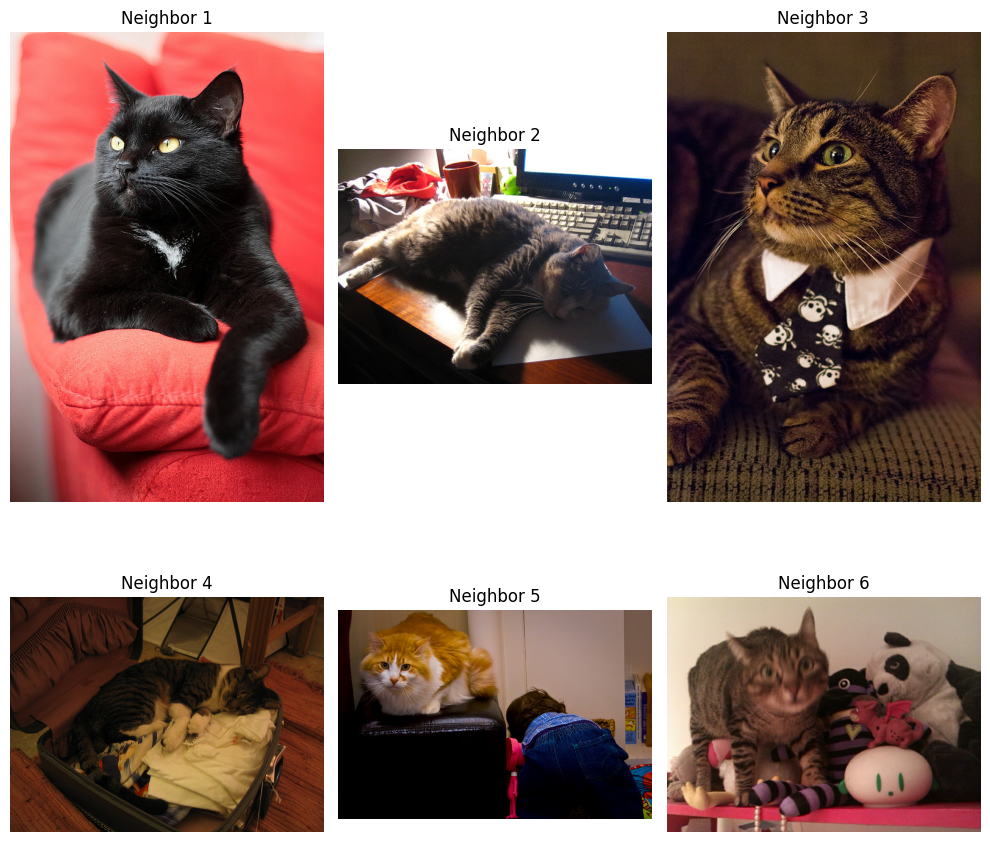

In [25]:
num_neighbors = len(indices)
num_rows = int(num_neighbors**0.5)
num_cols = int(np.ceil(num_neighbors / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_neighbors:
        x = load_image_from_url(dataset["url"][indices[i]])
        ax.imshow(x)
        ax.set_title(f"Neighbor {i + 1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

### Testing KD-Tree on Text Data

In [29]:
test_point = 110
# dataset["sentences"][test_point]

In [27]:
start = time.time()
# Build kdtree on text data
kdtree = KDTree(text_data, dimension = len(text_data[test_point][1]), distance_type='euclidean')
end_build = time.time()

# Retrieve the nearest neighbors for a test point
res = kdtree.nearest_neighbor(text_data[test_point][1], k=6)
end_search = time.time()
print(f"Time to build the KDTree: {end_build - start} seconds")
print(f"Time to build the KDTree and Search: {end_search - start} seconds")

Time to build the KDTree: 0.10464262962341309 seconds
Time to build the KDTree and Search: 0.18260812759399414 seconds


In [28]:
indices = [idx for idx, _ in [point for _, point in result]] if isinstance(res[0], tuple) else  [idx for idx, _ in result]
print("Nearset neighbors indices", indices, "\n")

sentences_to_print = [dataset["sentences"][i] for i in indices]
pprint.pprint(sentences_to_print, indent=4)

Nearset neighbors indices [6366, 6448, 10231, 3138, 14163, 12500] 

[   [   'A black cat sitting on a red sofa. ',
        'A black cat sitting on top of a red couch.',
        'Black and white cat on arm of red couch.',
        'A black cat posing on the arm of a couch and facing away from the '
        'camera.',
        'a black cat is sitting calmly on a red couch'],
    [   'A very cute cat laying on a desk.',
        'A cat is asleep on a piece of paper on a computer desk.',
        'A cat laying on a desk next to a keyboard.',
        'Cat lying on paper near electronic computer equipment on table.',
        'A cat laying on a desk in front of a keyboard. '],
    [   'a cat wearing a tie with skulls on it',
        'A cat is sporting a skull designed tie. ',
        'A cat sits with a tie around its neck.',
        'A cat sitting on a coach wearing a tie with skulls on it. ',
        'A cat laying down wearing a tie that has skulls on it.'],
    [   'A cute cat laying down in a 

## Approximate K-Nearest Neighbors with Locality-Sensitive Hashing (LSH) [60]

One effective approach to building an Approximate K-Nearest Neighbor (AKNN) search is by using Locality-Sensitive Hashing (LSH). LSH is a technique that hashes data points in such a way that similar points are more likely to fall into the same hash "bucket." This allows to search a smaller subset of the data for approximate nearest neighbors, making the search process faster, particularly in high-dimensional spaces like embeddings.

Read here: [LSH Paper](https://www.cs.princeton.edu/courses/archive/spring13/cos598C/Gionis.pdf)

> **Note**: LSH operates by reducing dimensional complexity and comparison count, so expect approximate (not exact) results.

The `__init__` method initializes the Locality-Sensitive Hashing (LSH) structure. It prepares the data points, sets up the hash table, and decides which distance metric to use (Euclidean or Cosine).

It sets up the necessary structure for efficiently storing and accessing data points based on similarity, using hash keys generated from random hyperplanes.

---

### `_generate_hyperplanes` Method:
This method generates random hyperplanes used to hash data points into different categories.

It creates the foundation for grouping similar data points together by generating random decision boundaries that will be used to assign points to specific buckets.

---

### `_generate_hash_key` Method:
This method creates a unique identifier (hash key) for each data point based on how the point compares to the generated hyperplanes.

It transforms each data point into a simple identifier (binary key), which helps in quickly finding similar points later by grouping them in the same bucket.

---

### `_query_hash_candidates` Method:
This method looks up potential neighbors of a query point in the hash table by generating multiple hash keys for the query.

It increases the chances of finding similar points by querying the hash table multiple times, ensuring a broader pool of candidates for comparison.

---

### `_create_hash_table` Method:
This method builds a table that associates each data point’s hash key with the points that share the same key.

It organizes the data into buckets based on the hash key, making it easier and faster to find similar points later on.

---

### `approximate_knn_search` Method:
This method performs a quick search to find the nearest neighbors to a query point using the pre-built hash table.

Here’s how the entire pipeline works:

### 1. **Initialization:**
   - When the `LSH` class is initialized, the data points are passed in, and the algorithm sets up essential structures:
     - **Data Storage**: The data points are stored in an array.
     - **Hyperplanes**: Random hyperplanes are generated. These hyperplanes will be used to hash the data points.
     - **Hash Table**: A hash table is created to store data points based on their hash keys.
---

### 2. **Hashing the Data Points:**
   - Every data point is transformed into a unique hash key using the hyperplanes.
   - The method `_generate_hash_key` decide the position of the point with respect to the hyperplane and based on this, a binary string (hash) is created for each point, representing which side of each hyperplane the point lies on.

---

### 3. **Storing Data Points in Buckets:**
   - The hash keys generated for each data point are used to store the points in a hash table.
   - If two data points share the same hash key, they are placed in the same bucket.

---

### 4. **Querying for Nearest Neighbors:**
   - When you query for the nearest neighbors of a point, the algorithm process the query point in the same way as the data points and then
   check it for candidate data points that share the same hash key.

---

### 5. **Candidate Selection and Refinement:**
   - The set of candidate points retrieved from the hash table is not guaranteed to contain the exact nearest neighbors, but they are likely to be similar.
   - The algorithm can query the hash table multiple times (controlled by the `repeat` parameter) to increase the chance of retrieving all relevant candidates.
   - After all candidates are retrived the alog will use distance to refine the retrived points.
---

### Final Flow:
1. **Initialization**: Set up data, hyperplanes, and hash table.
2. **Hashing**: Generate hash keys for each data point and store them in the hash table.
3. **Querying**: For a given query point, generate its hash keys and retrieve candidate points from the hash table.
4. **Refinement and Return**: Calculate distances and Return the top `k` nearest neighbors.

In [30]:
import numpy as np
from typing import List, Tuple

class LSH:
    def __init__(self, index_data: np.ndarray, bucket_size: int = 16, seed: int = 0, distance_type: str = 'cosine'):
        
        """
        Initialize LSH with data, bucket size, random seed, and distance type.

        :param index_data: Array of tuples where each tuple consists of an index and data point.
        :param bucket_size: Number of data points per bucket.
        :param seed: Seed for random number generator.
        :param distance_type: Type of distance metric, either 'euclidean' or 'cosine'.
        """

        self.indices, self.data = zip(*index_data)
        self.data = np.asarray(self.data)
        self.bucket_size = bucket_size
        self.rng = np.random.default_rng(seed)
        self.hyperplanes = self._generate_hyperplanes()
        self.hash_table = self._create_hash_table()

        if distance_type == 'euclidean':
            self.distance_func = self._euclidean_distance
        elif distance_type == 'cosine':
            self.distance_func = self._cosine_distance
        else:
            raise ValueError("Invalid distance type. Use 'euclidean' or 'cosine'.")

    def _generate_hyperplanes(self) -> np.ndarray:
        
        """
        Generate random hyperplanes for hashing based on feature dimensions and bucket size.

        :return: Array of hyperplanes for hashing data.
        """

        feature_dim = self.data.shape[1]
        num_hyperplanes = int(np.ceil(np.log2(len(self.data) / self.bucket_size)))
        return self.rng.normal(size=(num_hyperplanes, feature_dim))

    def _generate_hash_key(self, points: np.ndarray) -> np.ndarray:
        
        """
        Generate a hash key for given points based on the hyperplanes
        Remember that you need to convert the resulting binary hash into a decimal value.

        :param points: Array of data points to hash.
        :return: Hash keys for the data points.
        """

        projections = np.dot(points, self.hyperplanes.T)
        binary_hash = (projections > 0).astype(int)
        decimal_hash = binary_hash.dot(1 << np.arange(binary_hash.shape[1])[::-1])
        return decimal_hash

    def _query_hash_candidates(self, query: np.ndarray, repeat: int = 10) -> List[int]:
        
        """
        Retrieve candidates from hash table based on query and specified repeat count.

        :param query: Query data point.
        :param repeat: Number of times to hash the query for candidate retrieval.
        :return: List of candidate indices.
        """

        candidates = set()
        for _ in range(repeat):
            hash_key = self._generate_hash_key(query.reshape(1, -1))[0]
            candidates.update(self.hash_table.get(hash_key, []))
        return list(candidates)

    def _euclidean_distance(self, points: np.ndarray, query: np.ndarray) -> np.ndarray:
        
        """
        Compute Euclidean distance between points and query.

        :param points: Array of points to compare.
        :param query: Query point.
        :return: Array of distances.
        """

        return np.linalg.norm(points - query, axis=1)

    def _cosine_distance(self, points: np.ndarray, query: np.ndarray) -> np.ndarray:
        
        """
        Compute Cosine distance between points and query.

        :param points: Array of points to compare.
        :param query: Query point.
        :return: Array of cosine distances.
        """

        query_norm = np.linalg.norm(query)
        points_norm = np.linalg.norm(points, axis=1)
        cosine_similarity = np.dot(points, query) / (points_norm * query_norm)
        return 1 - cosine_similarity

    def _create_hash_table(self) -> dict:
        
        """
        Create a hash table for the LSH algorithm by mapping data points to hash buckets.

        :return: Hash table with keys as hash values and values as lists of data indices.
        """

        hash_table = {}
        hash_keys = self._generate_hash_key(self.data)
        for idx, key in zip(self.indices, hash_keys):
            if key not in hash_table:
                hash_table[key] = []
            hash_table[key].append(idx)
        return hash_table

    def approximate_knn_search(self, query: np.ndarray, k: int = 5, repeat: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        
        """
        Perform approximate K-nearest neighbor search on the query point.

        :param query: Query point for which nearest neighbors are sought.
        :param k: Number of neighbors to retrieve.
        :param repeat: Number of times to hash the query to increase candidate count.
        :return: Tuple of nearest points, their distances, and their original indices.
        """

        candidates_indices = self._query_hash_candidates(query, repeat=repeat)
        if not candidates_indices:
            return np.array([]), np.array([]), np.array([])

        candidates = self.data[list(candidates_indices)]
        distances = self.distance_func(candidates, query)
        sorted_indices = np.argsort(distances)[:k]
        nearest_points = candidates[sorted_indices]
        nearest_distances = distances[sorted_indices]
        nearest_indices = np.array(candidates_indices)[sorted_indices]

        return nearest_points, nearest_distances, nearest_indices


### Testing LSH on Images Data

In [31]:
image_data[110]

(12500,
 array([-6.20378351e+00, -2.02667999e+00, -2.95830011e+00, -3.15502119e+00,
        -1.96821582e+00, -4.63333941e+00, -5.08702564e+00, -3.42834187e+00,
        -2.03640842e+00, -5.41562748e+00, -3.95152235e+00, -5.34564257e+00,
        -2.86735082e+00, -4.63050365e+00, -3.76751971e+00, -1.86463201e+00,
        -3.84591126e+00, -3.62140369e+00, -2.58302021e+00, -4.74712372e+00,
        -4.46394205e+00, -3.40931153e+00, -6.15675163e+00, -3.14002514e+00,
        -8.55743825e-01, -3.46515656e+00, -4.96198082e+00, -4.43939257e+00,
        -2.73725581e+00, -7.52653241e-01, -2.16112518e+00, -2.45952892e+00,
        -3.25757074e+00, -3.47798443e+00, -3.02431893e+00, -3.34922433e+00,
        -1.29856920e+00, -1.73714495e+00, -5.61946869e-01, -2.25324130e+00,
        -4.59218693e+00, -3.29588556e+00, -4.62304115e+00, -3.99010491e+00,
        -4.04405355e+00, -1.44841433e+00, -3.03115749e+00, -2.89401031e+00,
        -3.27550268e+00, -4.74459839e+00, -3.59709233e-01,  3.41886973e+00,
    

In [32]:
test_point = 110
start = time.time()
lsh = LSH(image_data)
result = lsh.approximate_knn_search(image_data[test_point][1], k = 6)
end_build = time.time()
indices = result[2]
print(f"Time to build and seach in the LSH: {end_build - start} seconds\n")
print("Nearest neighbors indices", indices)

Time to build and seach in the LSH: 0.145859956741333 seconds

Nearest neighbors indices [1936 7011 2822 1748 4977 6319]


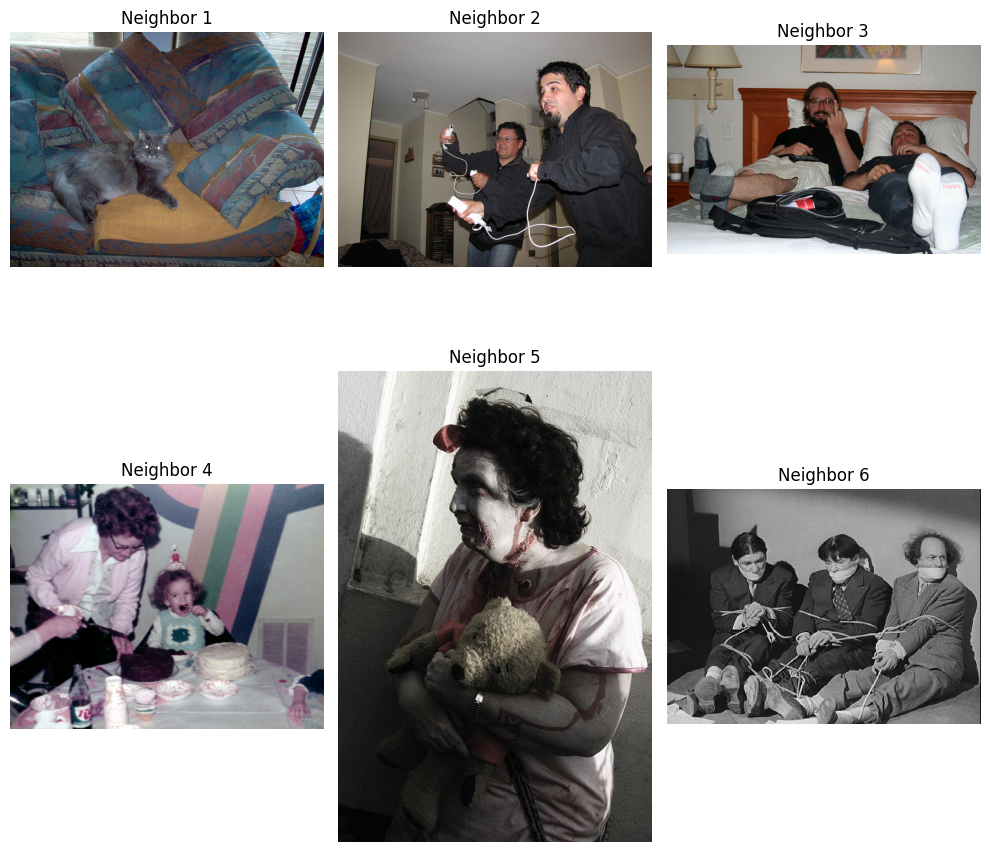

In [33]:
num_neighbors = len(indices)
num_rows = int(num_neighbors**0.5)
num_cols = int(np.ceil(num_neighbors / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_neighbors:
        x = load_image_from_url(dataset["url"][indices[i]])
        ax.imshow(x)
        ax.set_title(f"Neighbor {i + 1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

### Testing LSH on Text Data

In [34]:
start = time.time()
lsh = LSH(text_data)
result = lsh.approximate_knn_search(text_data[test_point][1], k = 6)
end_build = time.time()
indices = result[2]
print(f"Time to build and seach in the LSH: {end_build - start} seconds\n")
print("Nearest neighbors indices", indices)

Time to build and seach in the LSH: 0.09269547462463379 seconds

Nearest neighbors indices [ 2452  8978  8013 10381 10993 11613]


In [35]:
dataset["sentences"][test_point]

['A couple of men standing next to a street sign.',
 'A man in a blue shirt stands on a sidewalk in a large city.',
 'a yellow street sign stating when you can turn on a street',
 'a street sign near a tree with buildings in the bakground',
 'Several street signs shown on a city street.']

In [36]:
sentences_to_print = [dataset["sentences"][i] for i in indices]
pprint.pprint(sentences_to_print, indent=4)

[   [   'A group of police officers riding horses in a street.',
        'A stop sign on a road with vehicles and animals',
        'A view from a car window at an intersection on the street.',
        'A person in a car riding behind cops on horses.',
        'Cars are driving on a street past a horse.'],
    [   'A man riding a motorcycle with a woman on back of it.',
        'A man and a woman riding a scooter past a church.',
        'two people riding on a scooter on a city street',
        'People sit in front of a small white building.',
        'A man and woman pose for a photograph while sitting on a moped.'],
    [   'A large white cake sitting on top of a blue plate.',
        'square birthday cake with white frosting and five candles',
        'There are five lit candles on the home made birthday cake.',
        'A birthday cake with five lit candles sits on a plate.',
        'A cake with icing has five candles on it.'],
    [   'A cake sitting on top of a wooden table nex